An inference notebook for [**AnimeGAN**](https://github.com/TachibanaYoshino/AnimeGAN),
Made by Asher Chan.

If you like what I'm doing you can tip me and follow on [**Patreon**](https://www.patreon.com/Asher_Chan).    &nbsp;&nbsp;&nbsp;&nbsp;     ![visitors](https://visitor-badge.glitch.me/badge?page_id=AnimeGANv3&left_color=SeaGreen&right_color=Gold)

To start using this, run the cells with `Ctrl+F9` or "Runtime > Run All"

In [ ]:
#@title This colab is distributed under the AnimeGAN license
li = """License

This repo is made freely available to academic and 
non-academic entities for non-commercial purposes such 
as academic research, teaching, scientific publications. 
Permission is granted to use the AnimeGAN given 
that you agree to my license terms. Regarding the 
request for commercial use, please contact us via 
email to help you obtain the authorization letter."""
print(li)


License

This repo is made freely available to academic and 
non-academic entities for non-commercial purposes such 
as academic research, teaching, scientific publications. 
Permission is granted to use the AnimeGAN given 
that you agree to my license terms. Regarding the 
request for commercial use, please contact us via 
email to help you obtain the authorization letter.


In [ ]:
#@title Install and download. Run once.
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VPAPI84qaPUCHKHJLHiMK7BP_JE66xNe' -O AnimeGAN_Hayao.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17XRNQgQoUAnu6SM5VgBuhqSBO4UAVNI1' -O AnimeGANv2_Hayao.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10rQfe4obW0dkNtsQuWg-szC4diBzYFXK' -O AnimeGANv2_Shinkai.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1X3Glf69Ter_n2Tj6p81VpGKx7U4Dq-tI' -O AnimeGANv2_Paprika.onnx

!pip -qq install opencv-python
!pip -qq install numpy
!pip -qq install onnxruntime-gpu

In [ ]:
#@title Define functions
#@markdown Select model version and run.
import onnxruntime as ort
import time, cv2, PIL
import numpy as np
from tqdm.notebook import tqdm

pic_form = ['.jpeg','.jpg','.png','.JPEG','.JPG','.PNG']
device_name = ort.get_device()

if device_name == 'cpu':
    providers = ['CPUExecutionProvider']
elif device_name == 'GPU':
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']

model = 'AnimeGANv2_Paprika' #@param ['AnimeGAN_Hayao','AnimeGANv2_Hayao','AnimeGANv2_Shinkai','AnimeGANv2_Paprika']
#load model
session = ort.InferenceSession(f'/content/{model}.onnx', providers=providers)

def process_image(img, x32=True):
    h, w = img.shape[:2]
    if x32: # resize image to multiple of 32s
        def to_32s(x):
            return 256 if x < 256 else x - x%32
        img = cv2.resize(img, (to_32s(w), to_32s(h)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/ 127.5 - 1.0
    return img

def load_test_data(image_path):
    img0 = cv2.imread(image_path).astype(np.float32)
    img = process_image(img0)
    img = np.expand_dims(img, axis=0)
    return img, img0.shape[:2]


def Convert(img, scale):
    x = session.get_inputs()[0].name
    y = session.get_outputs()[0].name
    fake_img = session.run(None, {x : img})[0]
    images = (np.squeeze(fake_img) + 1.) / 2 * 255
    images = np.clip(images, 0, 255).astype(np.uint8)
    output_image = cv2.resize(images, (scale[1],scale[0]))
    return cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    

in_dir = '/content/in'
out_dir = f"/content/outputs"

#setup colab interface
from google.colab import files
import ipywidgets as widgets
from IPython.display import clear_output 
from IPython.display import display
import os
from glob import glob

def reset(p):
  with output_reset:
    clear_output()
  clear_output()
  process()
 
button_reset = widgets.Button(description="Upload")
output_reset = widgets.Output()
button_reset.on_click(reset)

 
def show_img(result_folder, size=384):
  line_img = PIL.Image.new('RGB', (size * 5, size), 0)
  col_num = 0
  for file_name in sorted(os.listdir(result_folder)):
    if file_name.endswith(".jpg"):
      image_result = PIL.Image.open(os.path.join(result_folder, file_name))
      image_result = image_result.resize((size,size))
      line_img.paste(image_result, (col_num * size, 0))
      col_num += 1
      if col_num == 5:
        display(line_img)
        line_img = PIL.Image.new('RGB', (size * 5, size), 0)
        col_num = 0
  if col_num != 0:
    display(line_img)


def process(upload=True):
  os.makedirs(in_dir, exist_ok=True)
  %cd {in_dir}/
  %rm -rf {out_dir}/*
  os.makedirs(out_dir, exist_ok=True)
  in_files = sorted(glob(f'{in_dir}/*'))
  if (len(in_files)==0) | (upload):
    %rm -rf {in_dir}/*
    uploaded = files.upload()
    if len(uploaded.keys())<=0: 
      print('\nNo files were uploaded. Try again..\n')
      return
  
  # Process the uploaded image.
  in_files = sorted(glob(f'{in_dir}/*'))
  in_files = [ x for x in in_files if os.path.splitext(x)[-1] in pic_form]
  for ims in tqdm(in_files):
    out_name = f"{out_dir}/{ims.split('/')[-1].split('.')[0]}.jpg"
    mat, scale = load_test_data(ims) 
    res = Convert(mat, scale)
    cv2.imwrite(out_name, res)

  # Get the compressed package of the output results
  out_zip = f"{out_dir}.zip"
  !zip {out_zip} {out_dir}/*
    
  # Visualize the result picture
  show_img(out_dir)



Press the button and pick some photos to upload

/content/in


Saving 1_out.jpg to 1_out.jpg
Saving 2_out.jpg to 2_out.jpg
Saving 3_out.jpg to 3_out.jpg
Saving 4_out.jpg to 4_out.jpg
Saving 5_out.jpg to 5_out.jpg
Saving 6_out.jpg to 6_out.jpg
Saving 7_out.jpg to 7_out.jpg


  0%|          | 0/7 [00:00<?, ?it/s]

updating: content/outputs/1_out.jpg (deflated 0%)
updating: content/outputs/2_out.jpg (deflated 0%)
updating: content/outputs/3_out.jpg (deflated 0%)
updating: content/outputs/4_out.jpg (deflated 0%)
updating: content/outputs/5_out.jpg (deflated 0%)
updating: content/outputs/6_out.jpg (deflated 0%)
updating: content/outputs/7_out.jpg (deflated 0%)


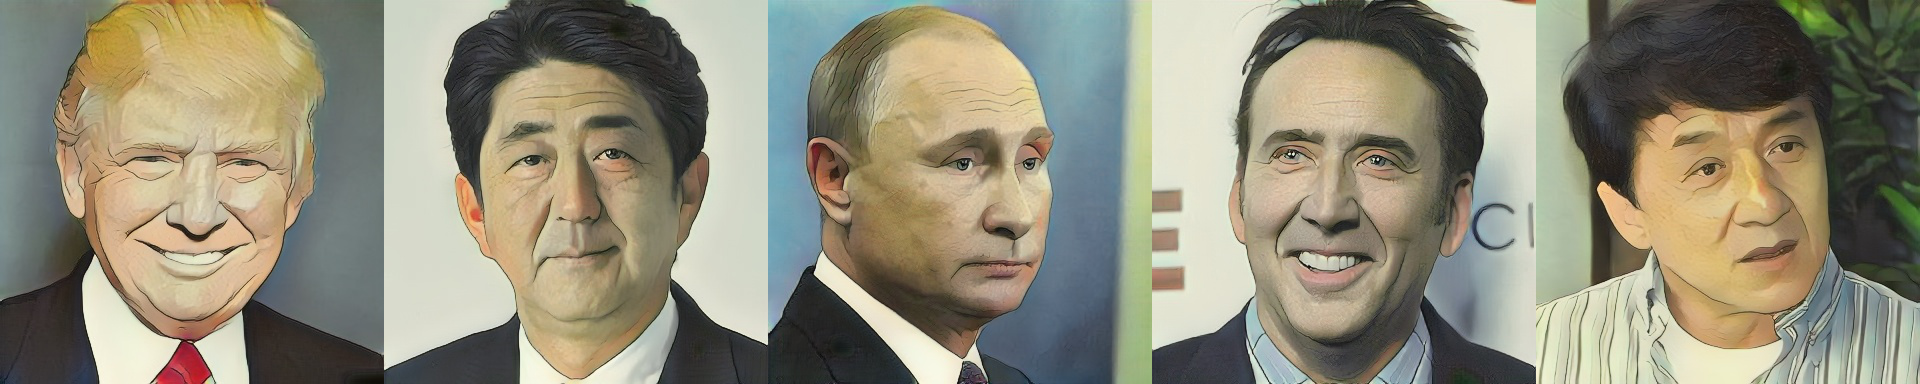

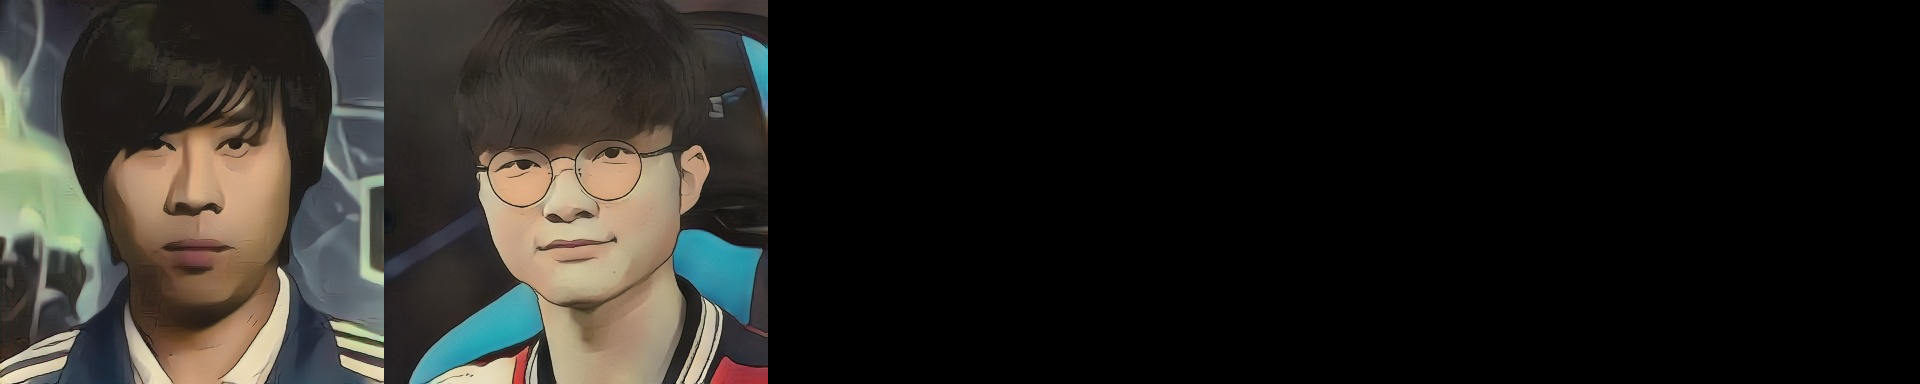

In [ ]:
#@title Click to upload files and run inference. Results will be saved and zipped.
print('\nPress the button and pick some photos to upload\n')
process()